# Multi-Task Learning (MTL) Strategies on MNIST Digits

This notebook provides a hands-on comparison of different approaches to Multi-Task Learning (MTL) using a simplified Multi-Layer Perceptron (MLP) architecture on a derivative of the MNIST dataset. We will investigate:

1.  **Single-Task Learning (STL):** Training independent models for each task.
2.  **Hard Parameter Sharing:** Sharing initial layers across tasks.
3.  **Soft Parameter Sharing (Cross-Stitch Networks):** Learning to combine task-specific activations.

**Tasks:** Binary classification on MNIST digits: "Is Even?" and "Is Multiple of 3 (excluding 0)?".

---

## 1. Setup and Global Configurations

We begin by importing the necessary libraries and defining global configurations, including the device for computation (CPU for broader compatibility), batch size, learning rate, and number of training epochs.

### 1.1 Imports and Device Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import time
import pandas as pd # Import pandas for improved table printing

# --- Global Configuration ---
# Set the device for training (GPU if available, otherwise CPU)
# Modified to force CPU usage to avoid potential CUDA environment errors.
device = torch.device("cpu")
print(f"Using device: {device}")

# Hyperparameters for training
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # Reduced number of epochs for quicker demonstration

Using device: cpu


---

## 2. Custom Dataset Preparation

To demonstrate multi-task learning, we'll create a custom dataset from MNIST that generates labels for two distinct binary classification tasks: checking if a digit is even, and checking if it's a multiple of 3 (excluding zero).

The `MNISTCustomTasks` class inherits from `torch.utils.data.Dataset`, which is the base class for datasets in PyTorch. Custom datasets must implement `__len__` (to return the dataset size) and `__getitem__` (to return a sample by index).

Standard transformations are applied to the MNIST images, including converting them to PyTorch tensors and normalizing their pixel values.

### 2.1 MNISTCustomTasks Class

In [2]:
class MNISTCustomTasks(Dataset): # Inherits from torch.utils.data.Dataset: Base class for datasets. Custom datasets must override __len__ and __getitem__.
    """
    A custom Dataset class to create two binary classification tasks from MNIST:
    Task 1: Is the digit Even or Odd?
    Task 2: Is the digit a Multiple of 3 (excluding 0)?
    """
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        # The length of our custom dataset is the same as the original MNIST dataset
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        # Get the image and original label from MNIST
        image, label = self.mnist_dataset[idx]

        # Task 1: Is Even? (0 for Even, 1 for Odd)
        task1_label = 0 if label % 2 == 0 else 1
        # Task 2: Is Multiple of 3 (excluding 0)? (0 for No, 1 for Yes)
        task2_label = 1 if label % 3 == 0 and label != 0 else 0

        # Return the image and the labels for both tasks
        return image, torch.tensor(task1_label, dtype=torch.long), torch.tensor(task2_label, dtype=torch.long)

### 2.2 Transformations and DataLoaders

In [3]:
# Define standard transformations for MNIST images
transform = transforms.Compose([ # torchvision.transforms.Compose: Chains multiple image transformations together.
    transforms.ToTensor(), # torchvision.transforms.ToTensor: Converts a PIL Image or NumPy array to a PyTorch Tensor, scaling pixel values to [0.0, 1.0].
    transforms.Normalize((0.1307,), (0.3081,)) # torchvision.transforms.Normalize: Normalizes a tensor image with mean and standard deviation. Critical for stable training.
])

# Download and prepare the MNIST datasets
# torchvision.datasets.MNIST: A Dataset class for the MNIST dataset, handling download and loading.
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create our custom task datasets from MNIST
train_dataset = MNISTCustomTasks(train_mnist)
test_dataset = MNISTCustomTasks(test_mnist)

# Create DataLoaders to efficiently load data in batches
# torch.utils.data.DataLoader: An iterator that provides efficient batching, shuffling, and multi-process data loading from a Dataset.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names for plotting confusion matrices
classes_task1 = ['Even', 'Odd']
classes_task2 = ['Not Multiple of 3', 'Multiple of 3']

---

## 3. Model Architectures

We define a base MLP architecture and then implement three distinct models based on parameter sharing strategies: Single-Task Learning (STL), Hard Parameter Sharing for MTL, and Cross-Stitch Networks for Soft Parameter Sharing.

### 3.1 Base MLP Architecture (`MLP`)

This `MLP` serves as the fundamental building block for our models, particularly for the STL approach. It's a simple feed-forward network with fixed hidden layer sizes.

In [4]:
class MLP(nn.Module): # Inherits from torch.nn.Module: Base class for all neural network modules. Manages parameters and child modules.
    """
    A simple, fixed Multi-Layer Perceptron (MLP) architecture.
    Used as the base for Single-Task Learning models.
    """
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, num_classes=2):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # torch.nn.Flatten: Flattens the input tensor (e.g., image) into a 1D vector.
                                    # Explanation: This layer is crucial for preparing multi-dimensional input data,
                                    # such as images (which are typically 2D or 3D, e.g., [channels, height, width]),
                                    # to be fed into fully connected (linear) layers. Fully connected layers expect
                                    # a 1D vector of features for each sample. `nn.Flatten()` reshapes the input
                                    # into a single long vector while keeping the batch dimension intact.
                                    # For example, a 28x28 grayscale image (input size 784) will be flattened from
                                    # [batch_size, 1, 28, 28] to [batch_size, 784].
        self.fc1 = nn.Linear(input_size, hidden_size1) # torch.nn.Linear: Implements a linear transformation (fully connected layer): y = xW^T + b.
        self.relu = nn.ReLU() # torch.nn.ReLU: Rectified Linear Unit activation function; introduces non-linearity.
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # torch.nn.Linear
        self.fc3 = nn.Linear(hidden_size2, num_classes) # torch.nn.Linear

    def forward(self, x): # The forward method defines how data flows through the network. Automatically called on model(input).
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### 3.2 Single-Task Learning Model (`STLModel`)

The `STLModel` is a simple wrapper around our `MLP` for clarity when performing single-task learning. Each task will have its own independent `STLModel`.

In [5]:
class STLModel(nn.Module): # Inherits from torch.nn.Module
    """
    Wrapper for a Single-Task Learning (STL) model.
    It simply uses the FixedMLP for a specific task.
    """
    def __init__(self, input_size, num_classes):
        super(STLModel, self).__init__()
        self.mlp = MLP(input_size, num_classes=num_classes)

    def forward(self, x):
        return self.mlp(x)

### 3.3 Hard Parameter Sharing MTL Model (`HardSharedMLP`)

This model uses a "hard" parameter sharing strategy, where the initial layers of the network are shared across both tasks, while the final layers are task-specific. This forces the shared layers to learn representations useful for both tasks.

In [6]:
class HardSharedMLP(nn.Module): # Inherits from torch.nn.Module
    """
    Multi-Task Learning (MTL) model with Hard Parameter Sharing.
    Initial layers are shared across both tasks, then separate "heads"
    handle task-specific predictions.
    """
    def __init__(self, input_size, shared_hidden_size=256, task_hidden_size=128, num_classes_task1=2, num_classes_task2=2):
        super(HardSharedMLP, self).__init__()
        self.flatten = nn.Flatten()

        # Shared layers: these layers learn features common to both tasks
        self.shared_fc1 = nn.Linear(input_size, shared_hidden_size)
        self.relu = nn.ReLU()
        self.shared_fc2 = nn.Linear(shared_hidden_size, shared_hidden_size // 2) # Halve the size for the next shared layer

        # Task 1 specific head: processes shared features for Task 1
        self.task1_fc1 = nn.Linear(shared_hidden_size // 2, task_hidden_size)
        self.task1_output = nn.Linear(task_hidden_size, num_classes_task1)

        # Task 2 specific head: processes shared features for Task 2
        self.task2_fc1 = nn.Linear(shared_hidden_size // 2, task_hidden_size)
        self.task2_output = nn.Linear(task_hidden_size, num_classes_task2)

    def forward(self, x):
        x = self.flatten(x)
        # Pass input through shared layers
        shared_features = self.relu(self.shared_fc1(x))
        shared_features = self.relu(self.shared_fc2(shared_features))

        # Pass shared features through task-specific heads
        task1_out = self.relu(self.task1_fc1(shared_features))
        task1_out = self.task1_output(task1_out)

        task2_out = self.relu(self.task2_fc1(shared_features))
        task2_out = self.task2_output(task2_out)

        return task1_out, task2_out

### 3.4 Cross-Stitch Unit (`CrossStitchUnit`)

The `CrossStitchUnit` is the core component of Soft Parameter Sharing in Cross-Stitch Networks. It allows networks to learn an optimal linear combination of feature maps from different tasks at specific layers.

In [7]:
class CrossStitchUnit(nn.Module): # Inherits from torch.nn.Module
    """
    A Cross-Stitch unit for Soft Parameter Sharing.
    It learns a linear combination of feature maps from different tasks.
    """
    def __init__(self, num_features):
        super(CrossStitchUnit, self).__init__()
        # nn.Parameter: A Tensor that is a parameter of a Module. Automatically registered and optimized.
        # Initialize mixing parameters.
        # As per the original paper "Cross-stitch Networks for Multi-task Learning" by I. Misra, A. Shrivastava, A. Gupta, M. Hebert (CVPR 2016)
        # Paper Link: [Cross-stitch Networks for Multi-task Learning](https://arxiv.org/abs/1604.05315)
        #
        # Initialization:
        # The cross-stitch parameters (alpha_ij) are initialized to allow the network to initially behave
        # as if it were two completely independent single-task networks.
        # - self.alpha_11 and self.alpha_22 (diagonal elements): Initialized to ones (torch.ones(num_features)).
        #   This ensures that, at the beginning, each task's features (x1 for task 1, x2 for task 2) primarily
        #   contribute to their *own* respective outputs (out1 from x1, out2 from x2). This represents an identity mapping for each task's features.
        # - self.alpha_12 and self.alpha_21 (off-diagonal elements): Initialized to zeros (torch.zeros(num_features)).
        #   This means that, initially, there is no cross-task information flow; features from one task (e.g., x2)
        #   do not contribute to the other task's output (e.g., out1).
        #
        # This "identity" initialization provides a neutral starting point, allowing the optimization process
        # to learn the optimal amount and type of information sharing between tasks during training, without
        # imposing strong assumptions about cross-task dependencies from the start.
        self.alpha_11 = nn.Parameter(torch.ones(num_features))
        self.alpha_12 = nn.Parameter(torch.zeros(num_features))
        self.alpha_21 = nn.Parameter(torch.zeros(num_features))
        self.alpha_22 = nn.Parameter(torch.ones(num_features))

    def forward(self, x1, x2):
        # The output for task 1 is a linear combination of its own features (x1)
        # and features from task 2 (x2). Similar for task 2.
        out1 = self.alpha_11 * x1 + self.alpha_12 * x2
        out2 = self.alpha_21 * x1 + self.alpha_22 * x2
        return out1, out2

### 3.5 Cross-Stitch Networks MTL Model (`CrossStitchMLP`)

Cross-Stitch Networks offer a Soft Parameter Sharing approach. Instead of rigidly sharing layers, they learn to combine the feature maps (activations) from task-specific network branches using learned scalar weights ($\alpha$) at different levels. This allows for a more flexible information flow between tasks.

The core component is the `CrossStitchUnit`. For activations $x_A^l, x_B^l$ from task A and B at layer $l$, the combined activations $\tilde{x}_A^l, \tilde{x}_B^l$ are:

$$
\begin{pmatrix} \tilde{x}_A^l \\ \tilde{x}_B^l \end{pmatrix} = \begin{pmatrix} \alpha_{AA} & \alpha_{AB} \\ \alpha_{BA} & \alpha_{BB} \end{pmatrix} \begin{pmatrix} x_A^l \\ x_B^l \end{pmatrix}
$$

where $\alpha_{AA}, \alpha_{AB}, \alpha_{BA}, \alpha_{BB}$ are learned scalars. This operation is applied element-wise across the activation tensors.

The `MultiTaskMLP_CrossStitch` model consists of parallel branches for each task, with `CrossStitchUnit` instances placed between corresponding layers.

In [8]:
class CrossStitchMLP(nn.Module): # Inherits from torch.nn.Module
    """
    Multi-Task Learning (MTL) model using Cross-Stitch Networks.
    Each task has its own MLP, but Cross-Stitch units are inserted
    between layers to allow learned information sharing.

    Software Architecture Overview:
    - Shared Input Processing: A common flattening layer for all inputs.
    - Task-Specific Feature Extractors: Independent MLP branches for each task (Task 1 and Task 2).
    - Learned Information Sharing: Cross-Stitch units strategically placed between layers
      of the task-specific branches to allow learned linear combinations of features.
    - Task-Specific Output Heads: Final linear layers that produce predictions for each task.
    """
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, num_classes_task1=2, num_classes_task2=2):
        super(CrossStitchMLP, self).__init__()

        # --- Input Processing Layer ---
        # This layer is applied universally to flatten the input image.
        self.flatten = nn.Flatten()

        # --- Task 1 Specific MLP Layers ---
        # These layers are part of the independent branch for Task 1.
        self.task1_fc1 = nn.Linear(input_size, hidden_size1)
        self.task1_fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.task1_output = nn.Linear(hidden_size2, num_classes_task1)

        # --- Task 2 Specific MLP Layers ---
        # These layers are part of the independent branch for Task 2.
        self.task2_fc1 = nn.Linear(input_size, hidden_size1)
        self.task2_fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.task2_output = nn.Linear(hidden_size2, num_classes_task2)

        # --- Cross-Stitch Units for Inter-Task Communication ---
        # These units are inserted between corresponding layers of the task-specific MLPs.
        # They learn how much information to pass between the branches.
        self.cross_stitch1 = CrossStitchUnit(hidden_size1) # Applied after the first hidden layer
        self.cross_stitch2 = CrossStitchUnit(hidden_size2) # Applied after the second hidden layer

        # --- Activation Function ---
        # ReLU is used consistently across all hidden layers.
        self.relu = nn.ReLU()

    def forward(self, x):
        # --- Stage 1: Flatten Input ---
        # The input 'x' (e.g., [batch_size, 1, 28, 28]) is flattened.
        # This flattened input is the starting point for both task-specific paths.
        x_flat = self.flatten(x)

        # --- Stage 2: First Hidden Layer Processing (Task-Specific Paths) ---
        # Each task processes the flattened input through its first dedicated linear layer.
        # Path for Task 1:
        features_t1_l1 = self.relu(self.task1_fc1(x_flat)) # [batch_size, hidden_size1]
        # Path for Task 2:
        features_t2_l1 = self.relu(self.task2_fc1(x_flat)) # [batch_size, hidden_size1]

        # --- Stage 3: Cross-Stitch Mixing (After First Hidden Layer) ---
        # The outputs from the first hidden layers of both tasks are fed into
        # the first Cross-Stitch unit. This unit learns to optimally combine features
        # from both tasks to produce refined features for the next layer.
        mixed_features_t1_l1, mixed_features_t2_l1 = self.cross_stitch1(features_t1_l1, features_t2_l1)

        # --- Stage 4: Second Hidden Layer Processing (Task-Specific Paths) ---
        # The mixed features from the first Cross-Stitch unit are then processed
        # by the second dedicated linear layer for each task.
        # Path for Task 1:
        features_t1_l2 = self.relu(self.task1_fc2(mixed_features_t1_l1)) # [batch_size, hidden_size2]
        # Path for Task 2:
        features_t2_l2 = self.relu(self.task2_fc2(mixed_features_t2_l1)) # [batch_size, hidden_size2]

        # --- Stage 5: Cross-Stitch Mixing (After Second Hidden Layer) ---
        # Similar to Stage 3, the outputs from the second hidden layers are
        # again mixed by the second Cross-Stitch unit.
        mixed_features_t1_l2, mixed_features_t2_l2 = self.cross_stitch2(features_t1_l2, features_t2_l2)

        # --- Stage 6: Task-Specific Output Layers ---
        # The final mixed features are passed through their respective output layers
        # to produce the logits (raw scores) for each task.
        task1_out = self.task1_output(mixed_features_t1_l2) # [batch_size, num_classes_task1]
        task2_out = self.task2_output(mixed_features_t2_l2) # [batch_size, num_classes_task2]

        return task1_out, task2_out

---

## 4. Training and Evaluation Functions

These functions encapsulate the core logic for training a model over multiple epochs, evaluating its performance on the test set, and collecting predictions for confusion matrix visualization.

In [9]:
def train_model(model, loader, optimizer, criterion, model_type="STL", num_epochs=NUM_EPOCHS):
    """
    Trains a given model and tracks training/validation metrics.
    Supports STL (Single-Task Learning) and MTL (Multi-Task Learning) models.
    """
    history = {'train_loss': [], 'train_acc_task1': [], 'train_acc_task2': [],
               'val_loss': [], 'val_acc_task1': [], 'val_acc_task2': []}
    best_val_accuracy = {'task1': 0.0, 'task2': 0.0, 'overall': 0.0} # To save the best model

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train() # model.train(): Sets the module to training mode. Affects BatchNorm, Dropout layers.
        total_loss = 0
        correct_task1 = 0
        correct_task2 = 0
        total_samples = 0

        for data, target_task1, target_task2 in loader:
            data = data.to(device) # .to(device): Moves a tensor or Module's parameters/buffers to the specified device (CPU/GPU).
            target_task1 = target_task1.to(device)
            target_task2 = target_task2.to(device)

            optimizer.zero_grad() # optimizer.zero_grad(): Zeros the gradients of all optimized tensors. Gradients accumulate by default.

            if model_type == "STL_Task1":
                output = model(data)
                loss = criterion(output, target_task1) # nn.CrossEntropyLoss: Computes the cross-entropy loss between output (logits) and target labels.
                preds_task1 = output.argmax(dim=1) # .argmax(dim=1): Returns the index of the maximum value along dimension 1 (typically the class with highest score).
                correct_task1 += (preds_task1 == target_task1).sum().item() # .item(): Extracts the scalar value from a 0-dimensional tensor.
            elif model_type == "STL_Task2":
                output = model(data)
                loss = criterion(output, target_task2)
                preds_task2 = output.argmax(dim=1)
                correct_task2 += (preds_task2 == target_task2).sum().item()
            elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
                output_task1, output_task2 = model(data)
                loss_task1 = criterion(output_task1, target_task1)
                loss_task2 = criterion(output_task2, target_task2)
                loss = loss_task1 + loss_task2 # Sum losses for Multi-Task Learning

                preds_task1 = output_task1.argmax(dim=1)
                preds_task2 = output_task2.argmax(dim=1)
                correct_task1 += (preds_task1 == target_task1).sum().item()
                correct_task2 += (preds_task2 == target_task2).sum().item()
            else:
                raise ValueError("Invalid model_type specified for training.")

            loss.backward() # .backward(): Computes the gradient of the loss with respect to all parameters that require gradients (backpropagation).
            optimizer.step() # optimizer.step(): Performs a single optimization step (updates model parameters based on gradients).
            total_loss += loss.item()
            total_samples += data.size(0)

        # Calculate average training metrics for the epoch
        avg_train_loss = total_loss / len(loader)
        train_acc_task1 = (correct_task1 / total_samples) * 100 if model_type != "STL_Task2" else 0.0
        train_acc_task2 = (correct_task2 / total_samples) * 100 if model_type != "STL_Task1" else 0.0

        history['train_loss'].append(avg_train_loss)
        history['train_acc_task1'].append(train_acc_task1)
        history['train_acc_task2'].append(train_acc_task2)

        # Validation step: evaluate model performance on the test set
        val_loss, val_acc_task1, val_acc_task2 = evaluate_model(model, test_loader, criterion, model_type)
        history['val_loss'].append(val_loss)
        history['val_acc_task1'].append(val_acc_task1)
        history['val_acc_task2'].append(val_acc_task2)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc T1: {train_acc_task1:.2f}% - Train Acc T2: {train_acc_task2:.2f}% - Val Loss: {val_loss:.4f} - Val Acc T1: {val_acc_task1:.2f}% - Val Acc T2: {val_acc_task2:.2f}%")

        # Save the best model based on validation accuracy
        if model_type == "STL_Task1" and val_acc_task1 > best_val_accuracy['task1']:
            best_val_accuracy['task1'] = val_acc_task1
            torch.save(model.state_dict(), f'best_stl_task1_model.pth') # torch.save: Saves a serialized object to disk. Used to save model state.
        elif model_type == "STL_Task2" and val_acc_task2 > best_val_accuracy['task2']:
            best_val_accuracy['task2'] = val_acc_task2
            torch.save(model.state_dict(), f'best_stl_task2_model.pth')
        elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
            # For MTL, consider the average accuracy of both tasks for 'best'
            avg_val_acc = (val_acc_task1 + val_acc_task2) / 2
            if avg_val_acc > best_val_accuracy['overall']:
                best_val_accuracy['overall'] = avg_val_acc
                torch.save(model.state_dict(), f'best_{model_type.lower()}_model.pth')

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training finished for {model_type}. Total time: {training_time:.2f}s")
    return history, training_time

In [10]:
def evaluate_model(model, loader, criterion, model_type="STL"):
    """
    Evaluates a trained model on a given data loader.
    Calculates loss and accuracy for the relevant tasks.
    """
    model.eval() # model.eval(): Sets the module to evaluation mode. Disables dropout, freezes BatchNorm statistics.
    total_loss = 0
    correct_task1 = 0
    correct_task2 = 0
    total_samples = 0

    with torch.no_grad(): # torch.no_grad(): A context manager that disables gradient calculation. Saves memory and speeds up inference.
        for data, target_task1, target_task2 in loader:
            data = data.to(device)
            target_task1 = target_task1.to(device)
            target_task2 = target_task2.to(device)

            if model_type == "STL_Task1":
                output = model(data)
                loss = criterion(output, target_task1)
                preds_task1 = output.argmax(dim=1)
                correct_task1 += (preds_task1 == target_task1).sum().item()
            elif model_type == "STL_Task2":
                output = model(data)
                loss = criterion(output, target_task2)
                preds_task2 = output.argmax(dim=1)
                correct_task2 += (preds_task2 == target_task2).sum().item()
            elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
                output_task1, output_task2 = model(data)
                loss_task1 = criterion(output_task1, target_task1)
                loss_task2 = criterion(output_task2, target_task2)
                loss = loss_task1 + loss_task2

                preds_task1 = output_task1.argmax(dim=1)
                preds_task2 = output_task2.argmax(dim=1)
                correct_task1 += (preds_task1 == target_task1).sum().item()
                correct_task2 += (preds_task2 == target_task2).sum().item()
            else:
                raise ValueError("Invalid model_type specified for evaluation.")

            total_loss += loss.item()
            total_samples += data.size(0)

    avg_loss = total_loss / len(loader)
    acc_task1 = (correct_task1 / total_samples) * 100 if model_type != "STL_Task2" else 0.0
    acc_task2 = (correct_task2 / total_samples) * 100 if model_type != "STL_Task1" else 0.0
    return avg_loss, acc_task1, acc_task2

In [11]:
def get_predictions(model, loader, device, model_type):
    """
    Gets predictions from the model for all samples in a loader.
    Returns true labels and predicted labels for each task.
    """
    model.eval()
    all_preds_task1 = []
    all_true_task1 = []
    all_preds_task2 = []
    all_true_task2 = []

    with torch.no_grad():
        for data, target_task1, target_task2 in loader:
            data = data.to(device)

            if model_type == "STL_Task1":
                output = model(data)
                preds = output.argmax(dim=1).cpu().numpy() # .cpu(): Moves the tensor to CPU memory. .numpy(): Converts a tensor to a NumPy array.
                all_preds_task1.extend(preds)
                all_true_task1.extend(target_task1.cpu().numpy())
            elif model_type == "STL_Task2":
                output = model(data)
                preds = output.argmax(dim=1).cpu().numpy()
                all_preds_task2.extend(preds)
                all_true_task2.extend(target_task2.cpu().numpy())
            elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
                output_task1, output_task2 = model(data)
                preds_task1 = output_task1.argmax(dim=1).cpu().numpy()
                preds_task2 = output_task2.argmax(dim=1).cpu().numpy()
                all_preds_task1.extend(preds_task1)
                all_true_task1.extend(target_task1.cpu().numpy())
                all_preds_task2.extend(preds_task2)
                all_true_task2.extend(target_task2.cpu().numpy())
    return (all_true_task1, all_preds_task1, all_true_task2, all_preds_task2)

### 4.4 Plotting Functions

These functions use `matplotlib` and `seaborn` to visualize training history (loss and accuracy curves) and confusion matrices, providing insights into model performance.

In [12]:
def plot_training_history(history, model_name, tasks_involved=['task1', 'task2']):
    """
    Plots the training and validation loss and accuracy over epochs.
    Adapts for single or multi-task models.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axes[0].plot(epochs, history['train_loss'], label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'{model_name} - Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy
    if 'task1' in tasks_involved and 'task2' in tasks_involved:
        # Plot both tasks if it's an MTL model
        axes[1].plot(epochs, history['train_acc_task1'], label='Train Acc Task 1', linestyle='--')
        axes[1].plot(epochs, history['val_acc_task1'], label='Val Acc Task 1', linestyle='--')
        axes[1].plot(epochs, history['train_acc_task2'], label='Train Acc Task 2', linestyle=':')
        axes[1].plot(epochs, history['val_acc_task2'], label='Val Acc Task 2', linestyle=':')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch (Tasks 1 & 2)')
    elif 'task1' in tasks_involved:
        # Plot only Task 1 if it's an STL model for Task 1
        axes[1].plot(epochs, history['train_acc_task1'], label='Train Acc Task 1')
        axes[1].plot(epochs, history['val_acc_task1'], label='Val Acc Task 1')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch (Task 1)')
    elif 'task2' in tasks_involved:
        # Plot only Task 2 if it's an STL model for Task 2
        axes[1].plot(epochs, history['train_acc_task2'], label='Train Acc Task 2')
        axes[1].plot(epochs, history['val_acc_task2'], label='Val Acc Task 2')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch (Task 2)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_custom(y_true, y_pred, classes, title_suffix=''):
    """
    Plots a confusion matrix using seaborn.
    Includes the overall accuracy in the title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix {title_suffix}\nAccuracy: {accuracy_score(y_true, y_pred):.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

---

## 5. Experiment Execution

In this section, we train and evaluate each model configuration (STL Task 1, STL Task 2, Hard Shared MTL, and Cross-Stitch MTL) sequentially. For each model, we will:
1. Initialize the model and its optimizer.
2. Train the model using the `train_model` function.
3. Plot the training history (loss and accuracy curves).
4. Load the best performing model (saved based on validation accuracy).
5. Generate predictions and plot confusion matrices for each task.
6. Store the final accuracy, training time, and number of learnable parameters.


--- Training STL for Task 1 (Is Even?) ---


Epoch 1/50 - Train Loss: 0.1079 - Train Acc T1: 95.92% - Train Acc T2: 0.00% - Val Loss: 0.0622 - Val Acc T1: 97.95% - Val Acc T2: 0.00%
Epoch 2/50 - Train Loss: 0.0498 - Train Acc T1: 98.26% - Train Acc T2: 0.00% - Val Loss: 0.0473 - Val Acc T1: 98.47% - Val Acc T2: 0.00%
Epoch 3/50 - Train Loss: 0.0365 - Train Acc T1: 98.79% - Train Acc T2: 0.00% - Val Loss: 0.0438 - Val Acc T1: 98.44% - Val Acc T2: 0.00%
Epoch 4/50 - Train Loss: 0.0286 - Train Acc T1: 99.03% - Train Acc T2: 0.00% - Val Loss: 0.0438 - Val Acc T1: 98.64% - Val Acc T2: 0.00%
Epoch 5/50 - Train Loss: 0.0224 - Train Acc T1: 99.25% - Train Acc T2: 0.00% - Val Loss: 0.0397 - Val Acc T1: 98.68% - Val Acc T2: 0.00%
Epoch 6/50 - Train Loss: 0.0174 - Train Acc T1: 99.40% - Train Acc T2: 0.00% - Val Loss: 0.0427 - Val Acc T1: 98.65% - Val Acc T2: 0.00%
Epoch 7/50 - Train Loss: 0.0154 - Train Acc T1: 99.48% - Train Acc T2: 0.00% - Val Loss: 0.0500 - Val Acc T1: 98.53% - Val Acc T2: 0.00%
Epoch 8/50 - Train Loss: 0.0133 - Train A

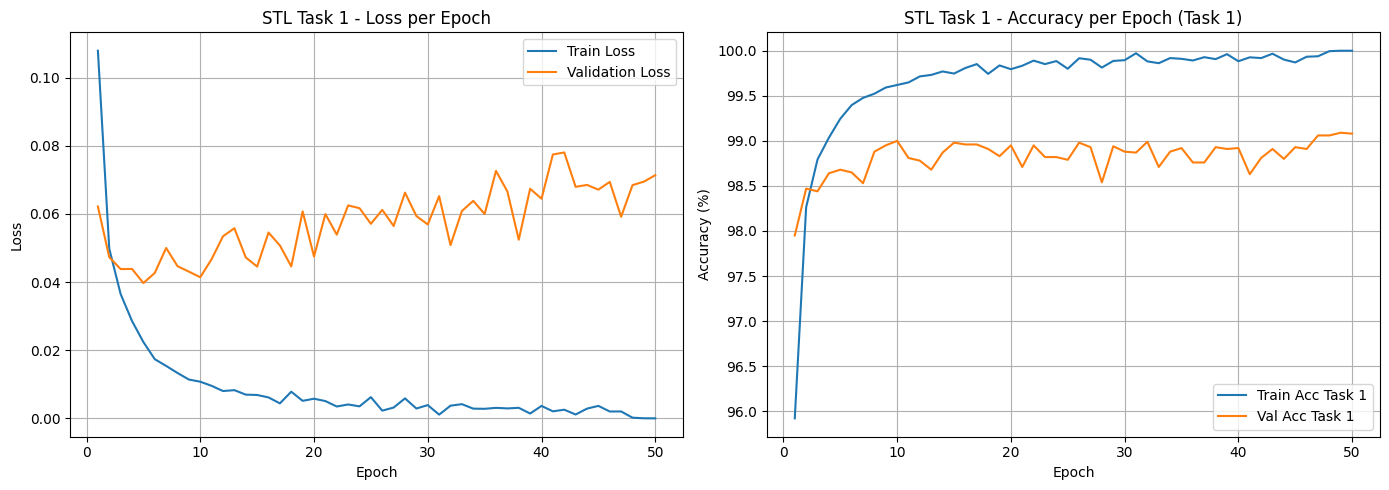

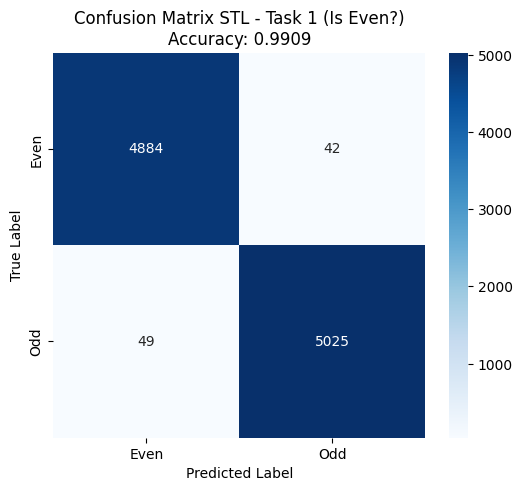


--- Training STL for Task 2 (Is Multiple of 3?) ---
Epoch 1/50 - Train Loss: 0.1269 - Train Acc T1: 0.00% - Train Acc T2: 95.14% - Val Loss: 0.0625 - Val Acc T1: 0.00% - Val Acc T2: 97.74%
Epoch 2/50 - Train Loss: 0.0583 - Train Acc T1: 0.00% - Train Acc T2: 97.94% - Val Loss: 0.0619 - Val Acc T1: 0.00% - Val Acc T2: 97.61%
Epoch 3/50 - Train Loss: 0.0412 - Train Acc T1: 0.00% - Train Acc T2: 98.51% - Val Loss: 0.0546 - Val Acc T1: 0.00% - Val Acc T2: 98.09%
Epoch 4/50 - Train Loss: 0.0302 - Train Acc T1: 0.00% - Train Acc T2: 98.92% - Val Loss: 0.0595 - Val Acc T1: 0.00% - Val Acc T2: 97.92%
Epoch 5/50 - Train Loss: 0.0250 - Train Acc T1: 0.00% - Train Acc T2: 99.17% - Val Loss: 0.0560 - Val Acc T1: 0.00% - Val Acc T2: 98.20%
Epoch 6/50 - Train Loss: 0.0210 - Train Acc T1: 0.00% - Train Acc T2: 99.28% - Val Loss: 0.0531 - Val Acc T1: 0.00% - Val Acc T2: 98.43%
Epoch 7/50 - Train Loss: 0.0167 - Train Acc T1: 0.00% - Train Acc T2: 99.38% - Val Loss: 0.0520 - Val Acc T1: 0.00% - Val Acc

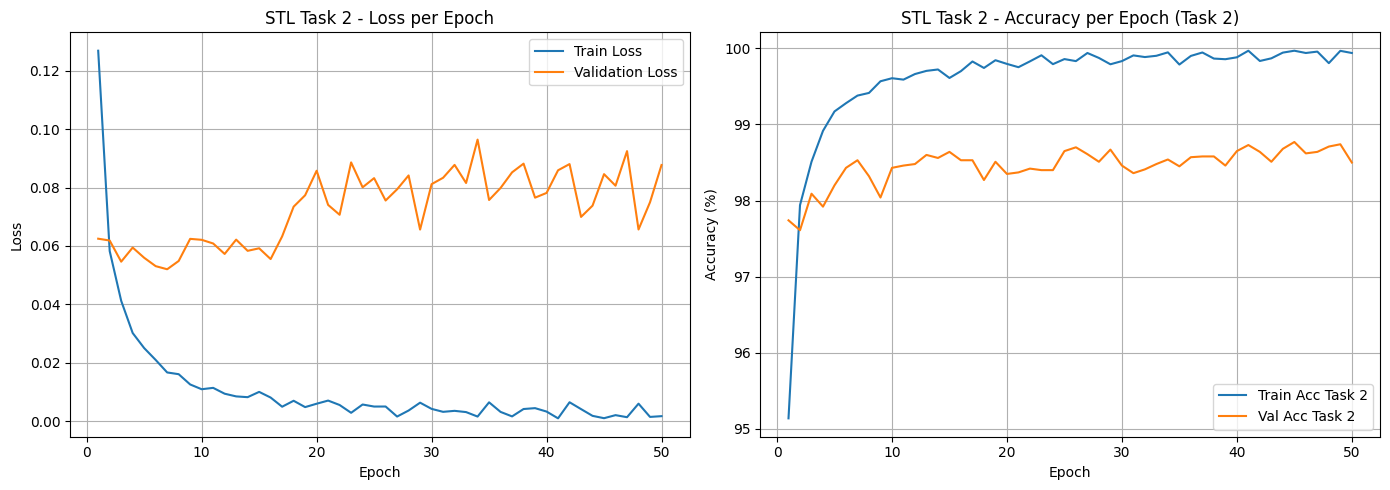

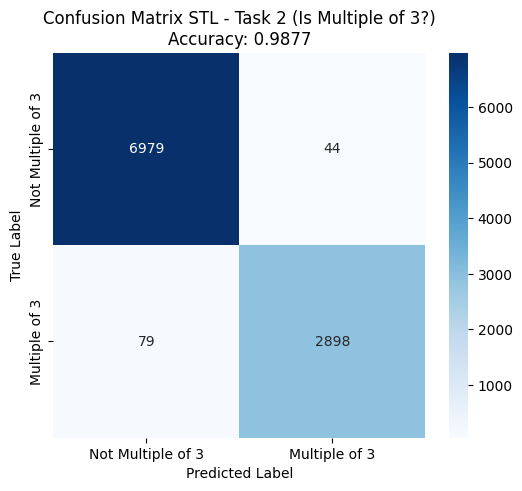


--- Training MTL with Hard Parameter Sharing ---
Epoch 1/50 - Train Loss: 0.2557 - Train Acc T1: 95.50% - Train Acc T2: 94.32% - Val Loss: 0.1140 - Val Acc T1: 98.05% - Val Acc T2: 97.72%
Epoch 2/50 - Train Loss: 0.1045 - Train Acc T1: 98.30% - Train Acc T2: 97.98% - Val Loss: 0.0883 - Val Acc T1: 98.56% - Val Acc T2: 98.26%
Epoch 3/50 - Train Loss: 0.0747 - Train Acc T1: 98.76% - Train Acc T2: 98.62% - Val Loss: 0.0833 - Val Acc T1: 98.63% - Val Acc T2: 98.31%
Epoch 4/50 - Train Loss: 0.0589 - Train Acc T1: 99.08% - Train Acc T2: 98.92% - Val Loss: 0.0833 - Val Acc T1: 98.75% - Val Acc T2: 98.53%
Epoch 5/50 - Train Loss: 0.0494 - Train Acc T1: 99.21% - Train Acc T2: 99.09% - Val Loss: 0.0868 - Val Acc T1: 98.67% - Val Acc T2: 98.49%
Epoch 6/50 - Train Loss: 0.0408 - Train Acc T1: 99.36% - Train Acc T2: 99.26% - Val Loss: 0.0786 - Val Acc T1: 98.66% - Val Acc T2: 98.57%
Epoch 7/50 - Train Loss: 0.0322 - Train Acc T1: 99.49% - Train Acc T2: 99.37% - Val Loss: 0.0927 - Val Acc T1: 98.79

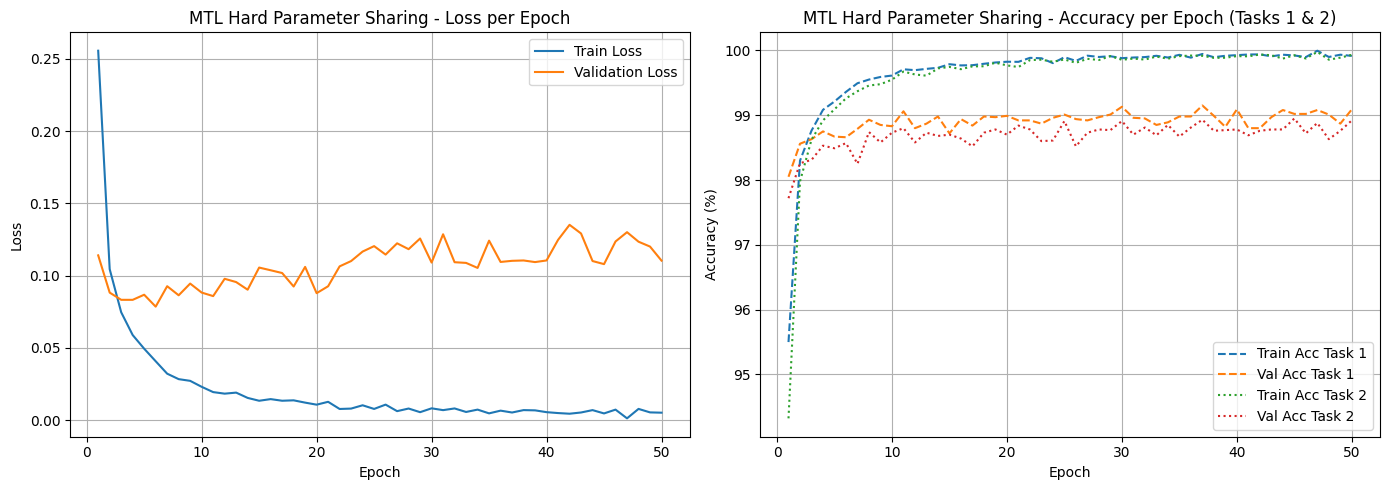

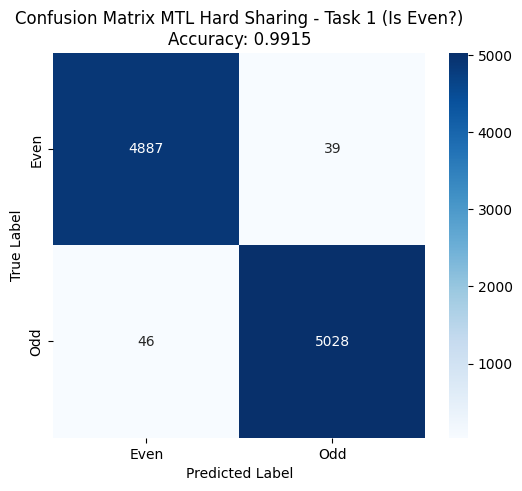

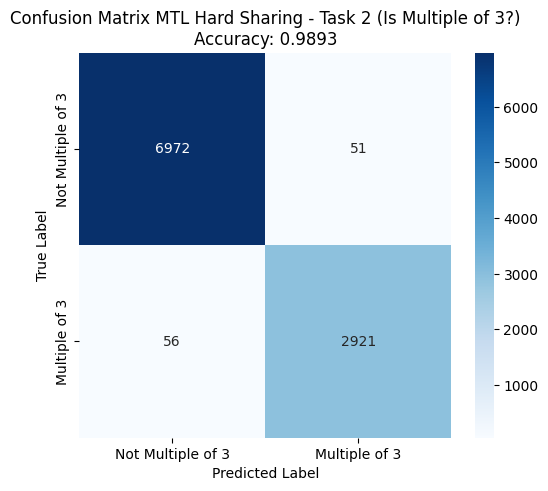


--- Training MTL with Cross-Stitch Networks ---
Epoch 1/50 - Train Loss: 0.2423 - Train Acc T1: 95.67% - Train Acc T2: 94.86% - Val Loss: 0.1294 - Val Acc T1: 97.83% - Val Acc T2: 97.81%
Epoch 2/50 - Train Loss: 0.1066 - Train Acc T1: 98.33% - Train Acc T2: 97.97% - Val Loss: 0.1013 - Val Acc T1: 98.32% - Val Acc T2: 97.97%
Epoch 3/50 - Train Loss: 0.0744 - Train Acc T1: 98.83% - Train Acc T2: 98.58% - Val Loss: 0.0862 - Val Acc T1: 98.66% - Val Acc T2: 98.32%
Epoch 4/50 - Train Loss: 0.0575 - Train Acc T1: 99.09% - Train Acc T2: 98.87% - Val Loss: 0.0806 - Val Acc T1: 98.76% - Val Acc T2: 98.49%
Epoch 5/50 - Train Loss: 0.0441 - Train Acc T1: 99.29% - Train Acc T2: 99.16% - Val Loss: 0.0982 - Val Acc T1: 98.77% - Val Acc T2: 98.15%
Epoch 6/50 - Train Loss: 0.0368 - Train Acc T1: 99.44% - Train Acc T2: 99.28% - Val Loss: 0.0879 - Val Acc T1: 98.80% - Val Acc T2: 98.39%
Epoch 7/50 - Train Loss: 0.0307 - Train Acc T1: 99.51% - Train Acc T2: 99.38% - Val Loss: 0.0948 - Val Acc T1: 98.73%

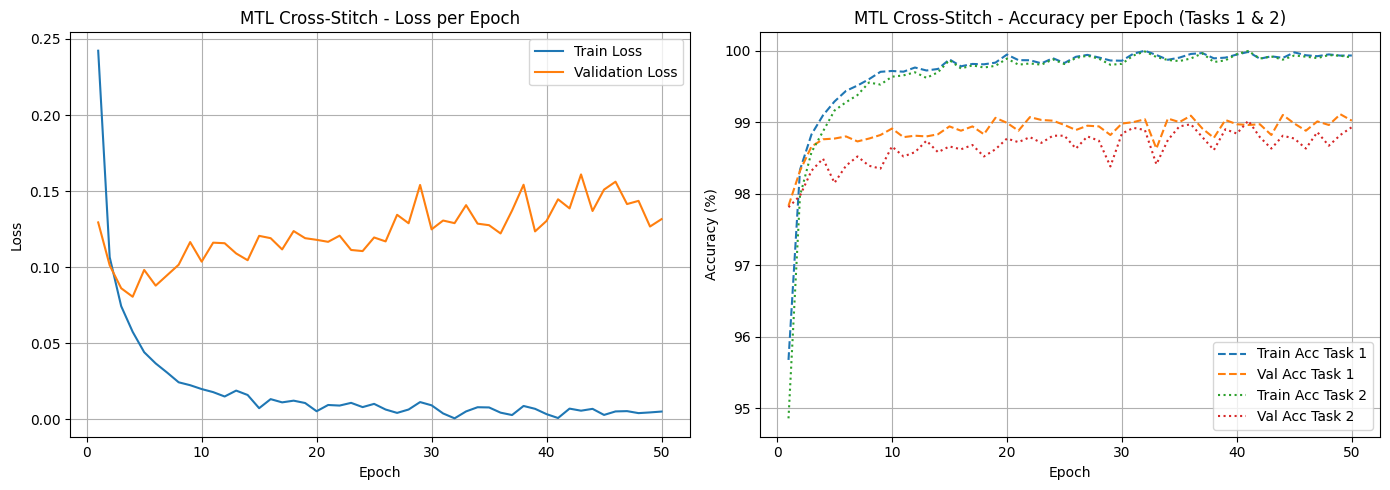

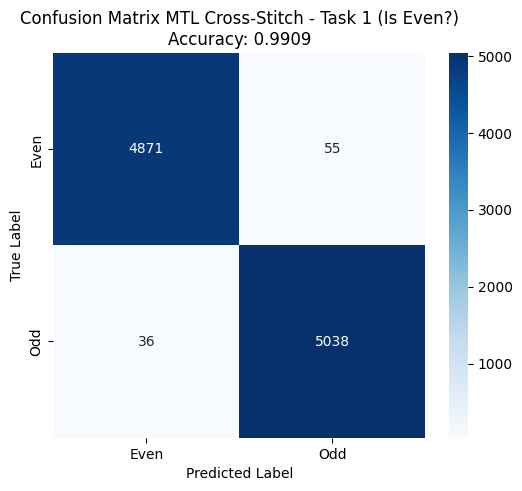

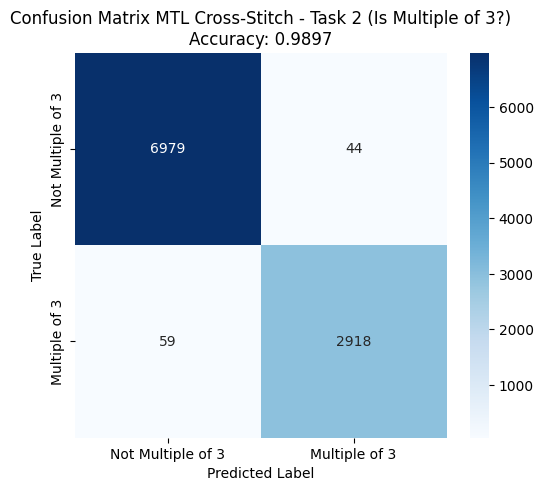

In [13]:
input_size = 28 * 28 # MNIST images are 28x28 pixels

results = {} # Dictionary to store summary metrics for all models

# 1. Single-Task Learning (STL)
print("\n--- Training STL for Task 1 (Is Even?) ---")
# Initialize STL model for Task 1 and its optimizer
model_stl_task1 = STLModel(input_size, num_classes=2).to(device)
# torch.optim.Adam: An adaptive learning rate optimizer. It computes individual adaptive learning rates for different parameters.
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=LEARNING_RATE) # model.parameters(): Returns an iterator over all learnable parameters of the model.
criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss: A common loss function for multi-class classification, combining LogSoftmax and NLLLoss.

# Train the STL model for Task 1
history_stl_task1, time_stl_task1 = train_model(model_stl_task1, train_loader, optimizer_stl_task1, criterion, model_type="STL_Task1")
plot_training_history(history_stl_task1, "STL Task 1", tasks_involved=['task1'])

# Evaluate and plot confusion matrix for Task 1 on the best model
model_stl_task1.load_state_dict(torch.load('best_stl_task1_model.pth')) # torch.load: Loads a serialized object from disk (e.g., a saved model's state dictionary).
# Get predictions for Task 1
true_t1, preds_t1, _, _ = get_predictions(model_stl_task1, test_loader, device, "STL_Task1")
plot_confusion_matrix_custom(true_t1, preds_t1, classes_task1, title_suffix="STL - Task 1 (Is Even?)")
# Get final evaluation metrics
final_eval_stl_t1 = evaluate_model(model_stl_task1, test_loader, criterion, "STL_Task1")
# Store results
results['STL_Task1'] = {'accuracy': final_eval_stl_t1[1], 'time': time_stl_task1, 'params': sum(p.numel() for p in model_stl_task1.parameters() if p.requires_grad)}


print("\n--- Training STL for Task 2 (Is Multiple of 3?) ---")
# Initialize STL model for Task 2 and its optimizer
model_stl_task2 = STLModel(input_size, num_classes=2).to(device)
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=LEARNING_RATE)

# Train the STL model for Task 2
history_stl_task2, time_stl_task2 = train_model(model_stl_task2, train_loader, optimizer_stl_task2, criterion, model_type="STL_Task2")
plot_training_history(history_stl_task2, "STL Task 2", tasks_involved=['task2'])

# Evaluate and plot confusion matrix for Task 2 on the best model
model_stl_task2.load_state_dict(torch.load('best_stl_task2_model.pth')) # Load the saved best model
# Get predictions for Task 2
_, _, true_t2, preds_t2 = get_predictions(model_stl_task2, test_loader, device, "STL_Task2")
plot_confusion_matrix_custom(true_t2, preds_t2, classes_task2, title_suffix="STL - Task 2 (Is Multiple of 3?)")
# Get final evaluation metrics
final_eval_stl_t2 = evaluate_model(model_stl_task2, test_loader, criterion, "STL_Task2")
# Store results
results['STL_Task2'] = {'accuracy': final_eval_stl_t2[2], 'time': time_stl_task2, 'params': sum(p.numel() for p in model_stl_task2.parameters() if p.requires_grad)}

# 2. Hard Parameter Sharing Multi-Task Learning (MTL)
print("\n--- Training MTL with Hard Parameter Sharing ---")
# Initialize Hard Shared MLP model and its optimizer
model_mtl_hard = HardSharedMLP(input_size).to(device)
optimizer_mtl_hard = optim.Adam(model_mtl_hard.parameters(), lr=LEARNING_RATE)

# Train the Hard Shared MTL model
history_mtl_hard, time_mtl_hard = train_model(model_mtl_hard, train_loader, optimizer_mtl_hard, criterion, model_type="MTL_Hard")
plot_training_history(history_mtl_hard, "MTL Hard Parameter Sharing")

# Evaluate and plot confusion matrices for Hard Parameter Sharing on the best model
model_mtl_hard.load_state_dict(torch.load('best_mtl_hard_model.pth')) # Load the saved best model
# Get predictions for both tasks
true_t1_mtl_hard, preds_t1_mtl_hard, true_t2_mtl_hard, preds_t2_mtl_hard = get_predictions(model_mtl_hard, test_loader, device, "MTL_Hard")
plot_confusion_matrix_custom(true_t1_mtl_hard, preds_t1_mtl_hard, classes_task1, title_suffix="MTL Hard Sharing - Task 1 (Is Even?)")
plot_confusion_matrix_custom(true_t2_mtl_hard, preds_t2_mtl_hard, classes_task2, title_suffix="MTL Hard Sharing - Task 2 (Is Multiple of 3?)")
# Get final evaluation metrics
final_eval_mtl_hard = evaluate_model(model_mtl_hard, test_loader, criterion, "MTL_Hard")
# Store results (note: time and params are common for both tasks in MTL)
results['MTL_Hard_Task1'] = {'accuracy': final_eval_mtl_hard[1], 'time': time_mtl_hard, 'params': sum(p.numel() for p in model_mtl_hard.parameters() if p.requires_grad)}
results['MTL_Hard_Task2'] = {'accuracy': final_eval_mtl_hard[2], 'time': time_mtl_hard, 'params': sum(p.numel() for p in model_mtl_hard.parameters() if p.requires_grad)}


# 3. Cross-Stitch Networks (Soft Parameter Sharing)
print("\n--- Training MTL with Cross-Stitch Networks ---")
# Initialize Cross-Stitch MLP model and its optimizer
model_mtl_cross = CrossStitchMLP(input_size).to(device)
optimizer_mtl_cross = optim.Adam(model_mtl_cross.parameters(), lr=LEARNING_RATE)

# Train the Cross-Stitch MTL model
history_mtl_cross, time_mtl_cross = train_model(model_mtl_cross, train_loader, optimizer_mtl_cross, criterion, model_type="MTL_CrossStitch")
plot_training_history(history_mtl_cross, "MTL Cross-Stitch")

# Evaluate and plot confusion matrices for Cross-Stitch on the best model
model_mtl_cross.load_state_dict(torch.load('best_mtl_crossstitch_model.pth')) # Load the saved best model
# Get predictions for both tasks
true_t1_mtl_cross, preds_t1_mtl_cross, true_t2_mtl_cross, preds_t2_mtl_cross = get_predictions(model_mtl_cross, test_loader, device, "MTL_CrossStitch")
plot_confusion_matrix_custom(true_t1_mtl_cross, preds_t1_mtl_cross, classes_task1, title_suffix="MTL Cross-Stitch - Task 1 (Is Even?)")
plot_confusion_matrix_custom(true_t2_mtl_cross, preds_t2_mtl_cross, classes_task2, title_suffix="MTL Cross-Stitch - Task 2 (Is Multiple of 3?)")
# Get final evaluation metrics
final_eval_mtl_cross = evaluate_model(model_mtl_cross, test_loader, criterion, "MTL_CrossStitch")
# Store results
results['MTL_CrossStitch_Task1'] = {'accuracy': final_eval_mtl_cross[1], 'time': time_mtl_cross, 'params': sum(p.numel() for p in model_mtl_cross.parameters() if p.requires_grad)}
results['MTL_CrossStitch_Task2'] = {'accuracy': final_eval_mtl_cross[2], 'time': time_mtl_cross, 'params': sum(p.numel() for p in model_mtl_cross.parameters() if p.requires_grad)}

---

## 6. Summary of Results

This section presents a consolidated table summarizing the performance metrics (accuracy, training time, and number of learnable parameters) for all trained models.

In [15]:
# --- Summary of Results ---
print("\n--- Summary of Results ---")

# Prepare data for a pandas DataFrame to achieve better table formatting.
# Seaborn is primarily for data visualization (plotting), not for rendering formatted text tables.
# Using pandas will give a clear, structured tabular output.
table_data = []

# Iterate through the results collected from model training
for model_name, metrics in results.items():
    if model_name.startswith("STL"):
        # For Single-Task Learning (STL) models, each entry corresponds to a distinct task.
        task_info = "Task 1 (Even)" if "Task1" in model_name else "Task 2 (Mult of 3)"
        table_data.append({
            "Model Type": model_name,
            "Task": task_info,
            "Accuracy (%)": f"{metrics['accuracy']:.2f}", # Format for consistent output
            "Training Time (s)": f"{metrics['time']:.2f}",
            "Learnable Parameters": metrics['params']
        })
    else: # Multi-Task Learning (MTL) models (Hard Shared or Cross-Stitch)
        # MTL models train both tasks simultaneously, so 'time' and 'params' apply to the whole model.
        # We'll represent this by listing both tasks but only showing time/params on the first task's row
        # for a given MTL model, and leaving it blank for the second task's row.
        base_model_name = model_name.replace('_Task1', '').replace('_Task2', '')
        if model_name.endswith("_Task1"): # Process MTL models only once for their shared metrics
            task1_acc = results[f'{base_model_name}_Task1']['accuracy']
            task2_acc = results[f'{base_model_name}_Task2']['accuracy']
            common_time = metrics['time']
            common_params = metrics['params']

            table_data.append({
                "Model Type": base_model_name,
                "Task": "Task 1 (Even)",
                "Accuracy (%)": f"{task1_acc:.2f}",
                "Training Time (s)": f"{common_time:.2f}",
                "Learnable Parameters": common_params
            })
            table_data.append({
                "Model Type": base_model_name,
                "Task": "Task 2 (Mult of 3)",
                "Accuracy (%)": f"{task2_acc:.2f}",
                "Training Time (s)": "-", # Indicate that time/params apply to the model as a whole
                "Learnable Parameters": "-"  # Use a hyphen for clarity, or leave blank if preferred
            })

# Create a pandas DataFrame from the prepared data
df_results = pd.DataFrame(table_data)

# Print the DataFrame to get a nicely formatted table.
# .to_string(index=False) prevents pandas from printing the DataFrame index.
print(df_results.to_string(index=False))


--- Summary of Results ---
     Model Type               Task Accuracy (%) Training Time (s) Learnable Parameters
      STL_Task1      Task 1 (Even)        99.09            736.59               234114
      STL_Task2 Task 2 (Mult of 3)        98.77            740.09               234114
       MTL_Hard      Task 1 (Even)        99.15            760.81               267396
       MTL_Hard Task 2 (Mult of 3)        98.93                 -                    -
MTL_CrossStitch      Task 1 (Even)        99.09            805.26               469764
MTL_CrossStitch Task 2 (Mult of 3)        98.97                 -                    -


---

## 7. Conclusion

This notebook demonstrates the implementation and comparison of different Multi-Task Learning strategies—Single-Task Learning, Hard Parameter Sharing, and Soft Parameter Sharing (Cross-Stitch Networks)—on a simplified MNIST digit classification problem.

Key takeaways often include:
* **Computational Efficiency:** MTL models can sometimes achieve comparable performance to STL models with fewer parameters or reduced training time, especially when tasks share underlying features.
* **Performance Synergy:** For related tasks, sharing information (either hard or soft) can lead to improved generalization or faster learning compared to training models in isolation.
* **Architectural Nuances:** Different sharing mechanisms (e.g., rigid vs. learned parameter sharing) offer varying degrees of flexibility and can perform differently depending on the task relationships.

Further exploration could involve tuning hyperparameters more extensively, experimenting with different backbone architectures, or applying these techniques to more complex and diverse tasks.